In [9]:
#Mine
import uproot
import pandas as pd
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt
import pickle
import atlasplots as ap
%matplotlib inline

In [17]:
df_evenc = pickle.load(open('./picklefiles/df_mc20_clean_conv_even.pickle', 'rb'))
df_oddc = pickle.load(open('./picklefiles/df_mc20_clean_conv_odd.pickle', 'rb'))
df_evenu = pickle.load(open('./picklefiles/df_mc20_clean_unconv_even.pickle', 'rb'))
df_oddu = pickle.load(open('./picklefiles/df_mc20_clean_unconv_odd.pickle', 'rb'))

In [20]:
sig_Et = ap.makebh(df_evenu,'y_pt',(0,200),boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkg_Et = ap.makebh(df_evenu,'y_pt',(0,200),boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')

In [21]:
bh.axis.Regular?
#figure out how to make this non-regular bins. May need different object

In [22]:
bh.axis.*?

In [23]:
bh.axis.Variable?
#this is what i need

In [24]:
# bh.axis.IntCategory?

## - make histo and plot to see


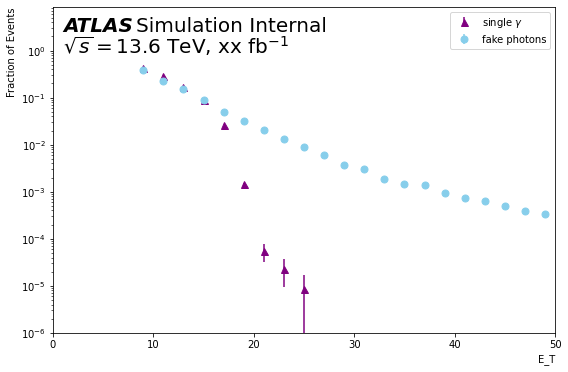

In [25]:
ap.ATLAShist(sig_Et,bkg_Et,'E_T',minmax=(0,50))

## - then see if can do custom binning like florian


In [26]:
binedgesET = [0,25,30,35,40,45,50,60,80,100,120,200,500,10000]  # end could be 1000 or more to include everything

In [27]:
def makebhvar(dataframe,branchname,binedges,boolslice=[],weightname='goodWeight'):
    '''a variable binning version of 'makebh', spits out only one boostHistogram
    
    dataframe is the the dataframe (pandas DataFrame)
    branchname is the name of the wanted branch (str)
    binedges is a list of bin edges, one more than number of bins
    boolslice is an optional boolean (list/array/Series) argument (boolean mask), if a slice of the data is wanted,
        for example: boolslice = dataframe.y_convType == 0 for converted
    weightname is the (str) of the key for the weights in the DataFrame dataframe.
    
    '''
    histo = bh.Histogram(bh.axis.Variable(binedges),storage=bh.storage.Weight()) 
    
    if bool(list(boolslice)) == True:
        histo.fill(dataframe[branchname][boolslice], weight=dataframe[weightname][boolslice])
    else:
        histo.fill(dataframe[branchname], weight=dataframe[weightname])
    
    return histo

In [28]:
sigvarET = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarET = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')

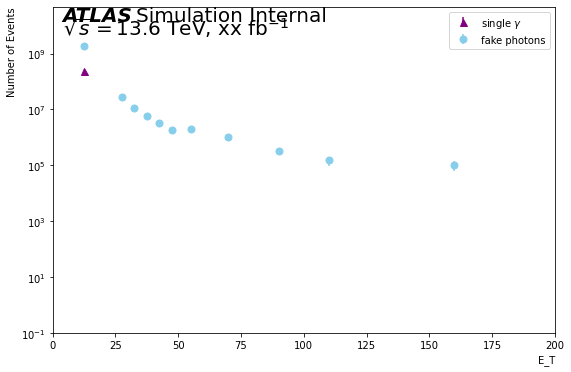

In [29]:
ap.ATLAShist(sigvarET,bkgvarET,'E_T',minmax=(0,200),norm=False)

## - then extract values for weighting via Heather's equation on paper


In [30]:
def histvals(hist1,norm=False):
    '''returns the values of the histogram bins of hist (bh_Histogram)
    
    norm = False (default) means its the number of events
    norm = True means its the fraction of events'''
    
    integral1 = hist1.sum().value
    
    if norm:
        vals = hist1.view().value/integral1
    elif ~norm:
        vals = hist1.view().value
    return vals

In [31]:
bkgvalsET = histvals(bkgvarET)
sigvalsET = histvals(sigvarET)    #SHOULD THESE BE NORMED OR NOT

In [32]:
ratioforsigET = bkgvalsET/sigvalsET   

/tmp/ipykernel_623/801728398.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ratioforsigET = bkgvalsET/sigvalsET
/tmp/ipykernel_623/801728398.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratioforsigET = bkgvalsET/sigvalsET


In [33]:
ratioforsigET,bkgvalsET, sigvalsET

(array([8.09599059,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        nan,        nan]),
 array([1.88897101e+09, 2.73349732e+07, 1.08035367e+07, 5.93089782e+06,
        3.18675112e+06, 1.83664687e+06, 1.91178907e+06, 1.04268904e+06,
        3.13194056e+05, 1.48960709e+05, 1.04413111e+05, 0.00000000e+00,
        0.00000000e+00]),
 array([2.3332179e+08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]))

## - then apply weights to specific events


In [34]:
len(binedgesET),len(ratioforsigET)

(14, 13)

In [9]:
def reweight(df,binedges,ratiolist,PTorETA='y_pt',sigorbkg='sig'):
    '''returns list of weights associated with applying
    binned weighting to the events in df_sig
    
    binedges is list of bin edges, length i+1
    ratiolist is list of reweighting ratios for each bin, length i
    PTorETA can be 'y_pt' (default) or 'y_eta' (or 'abs_eta' if made)
    sigorbkg can be 'sig' (default) or 'bkg'
        - this chooses whether the weighting is applied to the signal events or bkg events
    '''
    
    if sigorbkg == 'sig':
        truthsig = True
    elif sigorbkg == 'bkg':
        truthsig = False
    else:
        print('please pick \'sig\' or \'bkg\' for <sigorbkg>')
        return None
    
    eventlist = np.array(df[PTorETA])
    sigbkglist = np.array(df['y_isTruthMatchedPhoton'])
    reweightlist = []
    
    for event,sigbkg in zip(eventlist,sigbkglist):
        if sigbkg == truthsig:
            for i in range(len(ratiolist)):
                if (event>=binedges[i]) & (event<binedges[i+1]):
                    reweightlist.append(ratiolist[i])
        elif sigbkg != truthsig:
            reweightlist.append(1.)
        else:
            print('it should never get here, fix your code')
            return None
                
#     print('\nsize of eventlist: ',len(eventlist))
#     print('size of rewweightlist: ', len(reweightlist))
#     print('should match \n')
    
    return reweightlist

In [35]:
## HERE SHOULD I REWEIGHT THE SIG or REWEIGHT THE BKG

df_evenu['ETWeight'] = reweight(df_evenu,binedgesET,ratioforsigET,'y_pt')

NameError: name 'reweight' is not defined

In [10]:
binedgesETA = [0,0.6,0.8,1.15,1.37,1.52,1.81,2.01,2.37]

## - then replot to see if match.


## - ^to get similar match, may need to do eta first then E_t (to get what florian did)

# TRYING NOW WITH ETA

In [19]:
df_evenu['abs_eta'] = abs(df_evenu.y_eta)

In [20]:
sig_eta = ap.makebh(df_evenu,'abs_eta',(0,3),boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkg_eta = ap.makebh(df_evenu,'abs_eta',(0,3),boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')

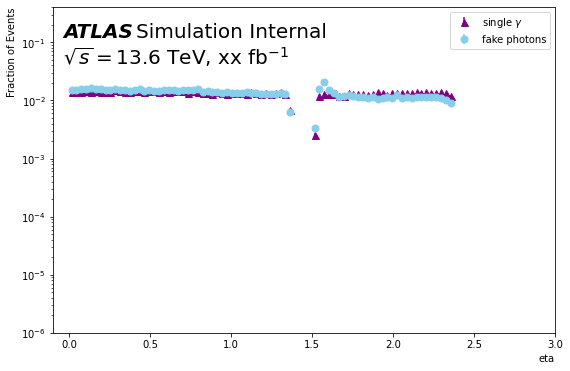

In [21]:
ap.ATLAShist(sig_eta,bkg_eta,'eta',minmax=(-0.1,3))

In [22]:
####
binedgesETA = [0,0.6,0.8,1.15,1.37,1.52,1.81,2.01,2.37]

In [23]:
sigvarETA = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarETA = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')

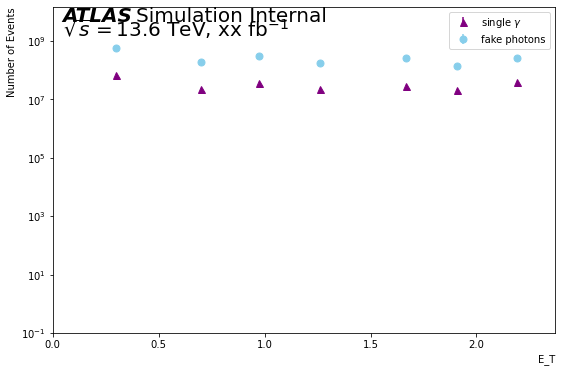

In [24]:
ap.ATLAShist(sigvarETA,bkgvarETA,'E_T',minmax=(0,2.37),norm=False)

In [25]:
bkgvalsETA = histvals(bkgvarETA)
sigvalsETA = histvals(sigvarETA)    #SHOULD THESE BE NORMED OR NOT, im choosing not

In [26]:
ratioforsigETA = bkgvalsETA/sigvalsETA
ratioforsigETA

/tmp/ipykernel_623/2977173927.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratioforsigETA = bkgvalsETA/sigvalsETA


array([8.93958993, 8.858339  , 8.63774781, 8.1342657 ,        nan,
       9.05982328, 7.04193032, 6.8699261 ])

In [27]:
df_evenu['etaWeight'] = reweight(df_evenu,binedgesETA,ratioforsigETA,'abs_eta')


size of eventlist:  226056
size of rewweightlist:  226056
should match 



In [28]:
df_evenu['newWeight'] = np.multiply( np.array(df_evenu.goodWeight), np.array(df_evenu.etaWeight) )
sigpostETA = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgpostETA = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')

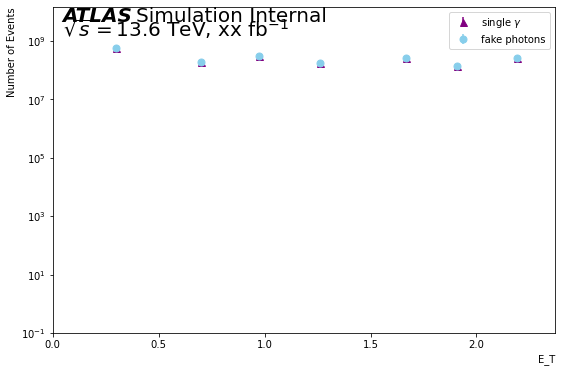

In [30]:
ap.ATLAShist(sigpostETA,bkgpostETA,'eta',minmax=(0,2.37),norm=False,log=False)  #plot ratio, uncertainty on ratio, horizontal error bars or histogram

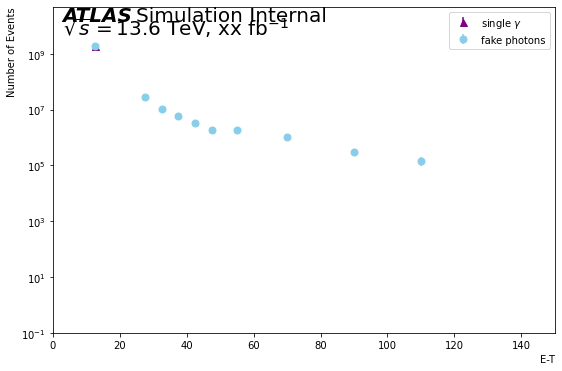

In [51]:
sigETpostETA = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgETpostETA = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
ap.ATLAShist(sigETpostETA,bkgETpostETA,'E-T',minmax=(0,150),norm=False)

# Now seeing with ET reweighting too

In [34]:
# df_evenu['combinedWeight'] = np.multiply( np.array(df_evenu.newWeight), np.array(df_evenu.ETWeight) )
# sigETAc = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='combinedWeight')
# bkgETAc = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='combinedWeight')
# sigETc = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='combinedWeight')
# bkgETc = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='combinedWeight')

In [35]:
# ap.ATLAShist(sigETAc,bkgETAc,'eta',minmax=(0,2.37),norm=False)

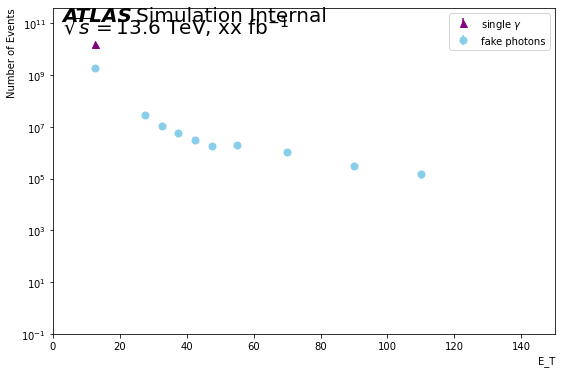

In [36]:
# ap.ATLAShist(sigETc,bkgETc,'E_T',minmax=(0,150),norm=False)

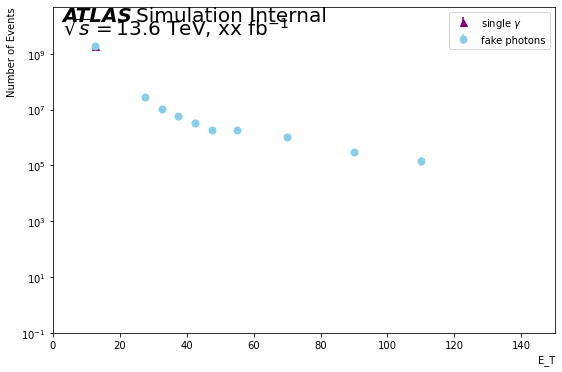

In [38]:
### REDOING THE E_T REWEIGHTING, inputting the "newWeight" that includes the eta reweighting

sigvarET = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvarET = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')


ap.ATLAShist(sigvarET,bkgvarET,'E_T',minmax=(0,150),norm=False)

In [39]:

bkgvalsET = histvals(bkgvarET)
sigvalsET = histvals(sigvarET) 

In [40]:
ratioforsigET = bkgvalsET/sigvalsET
ratioforsigET

/tmp/ipykernel_623/4243303016.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ratioforsigET = bkgvalsET/sigvalsET
/tmp/ipykernel_623/4243303016.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratioforsigET = bkgvalsET/sigvalsET


array([0.9729016,       inf,       inf,       inf,       inf,       inf,
             inf,       inf,       inf,       inf,       inf,       nan])

In [41]:
df_evenu['etWeight'] = reweight(df_evenu,binedgesET,ratioforsigET,'y_pt')


size of eventlist:  226056
size of rewweightlist:  226056
should match 



In [47]:
min(df_evenu['etWeight'])

0.9729015956474718

In [42]:
df_evenu['finalWeight'] = np.multiply( np.array(df_evenu.newWeight), np.array(df_evenu.etWeight) )


In [43]:
sigpost_eta = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='finalWeight')
bkgpost_eta = makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='finalWeight')
sigpost_et = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='finalWeight')
bkgpost_et = makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='finalWeight')

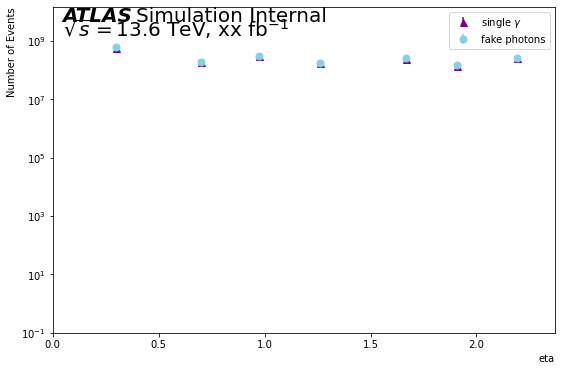

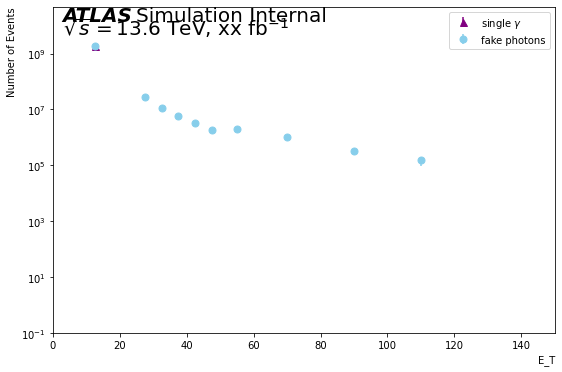

In [53]:
ap.ATLAShist(sigpost_eta,bkgpost_eta,'eta',minmax=(0,2.37),norm=False)
ap.ATLAShist(sigpost_et,bkgpost_et,'E_T',minmax=(0,150),norm=False)

In [50]:
df_evenu

,mcTotWeight,goodWeight,y_pt,y_eta,y_isTruthMatchedPhoton,y_convType,HadLeakage,y_Reta,y_weta2,y_Rphi,...,y_deltae_stand,y_Eratio_stand,y_f1_stand,ETWeight,abs_eta,etaWeight,newWeight,combinedWeight,etWeight,finalWeight
0,1550.033401,1641.816381,11.216813,1.092954,True,0,-0.021898,0.973289,0.010784,0.973692,...,-0.345338,0.803624,0.089686,8.095991,1.092954,8.637748,14181.595849,114814.066477,0.972902,13797.297230
2,18372.992460,18372.992460,9.305540,-1.351952,False,0,0.556643,0.709431,0.015106,0.785805,...,-0.410121,-0.115244,0.340115,1.000000,1.351952,1.000000,18372.992460,18372.992460,1.000000,18372.992460
4,20449.628899,21660.524007,10.097452,-0.982381,False,0,0.026651,0.977891,0.010399,0.961590,...,-0.368340,0.618557,0.003540,1.000000,0.982381,1.000000,21660.524007,21660.524007,1.000000,21660.524007
6,1263.713552,1244.314744,10.594992,-0.131329,True,0,-0.010028,1.000819,0.008862,1.009038,...,-0.380875,0.825092,0.724411,8.095991,0.131329,8.939590,11123.663550,90057.075377,0.972902,10822.230017
8,11422.256348,11422.256348,8.264909,1.756087,False,0,-0.104099,1.073294,0.009563,0.937752,...,-0.347452,0.578565,0.633879,1.000000,1.756087,1.000000,11422.256348,11422.256348,1.000000,11422.256348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452102,2243.064696,2208.632225,11.337442,-0.258049,True,0,-0.000516,0.961494,0.008476,0.991313,...,-0.414300,0.586178,-0.854758,8.095991,0.258049,8.939590,19744.266383,159849.394750,0.972902,19209.228269
452104,2079.039782,2202.147107,12.260214,1.356781,True,0,-0.003684,0.948381,0.010499,0.918204,...,-0.399672,0.851501,-0.548126,8.095991,1.356781,8.134266,17912.849685,145022.262409,0.972902,17427.440041
452106,1359.144485,1359.144485,9.960910,-1.020772,True,0,-0.005242,0.975148,0.011439,0.744668,...,-0.403853,0.543481,-0.093747,8.095991,1.020772,8.637748,11739.947299,95046.502810,0.972902,11421.813460
452108,2009.984644,2009.984644,9.824505,0.375722,True,0,-0.000477,0.922803,0.012383,0.859937,...,-0.376699,0.102684,1.814284,8.095991,0.375722,8.939590,17968.438469,145472.308684,0.972902,17481.522458


In [2]:
version = 'BACKW25mil_TESTwWEIGHT'

In [4]:
df_evenc = pickle.load(open('./picklefiles/'+version+'df_mc20_conv_even.pickle', 'rb'))
df_oddc = pickle.load(open('./picklefiles/'+version+'df_mc20_conv_odd.pickle', 'rb'))
# df_evenu = pickle.load(open('./picklefiles/'+version+'df_mc20_unconv_even.pickle', 'rb'))
# df_oddu = pickle.load(open('./picklefiles/'+version+'df_mc20_unconv_odd.pickle', 'rb'))

In [22]:
sigvarET = makebhvar(df_evenc,'y_pt',binedgesET,boolslice=df_evenc.y_isTruthMatchedPhoton,weightname='finalWeight')
bkgvarET = makebhvar(df_evenc,'y_pt',binedgesET,boolslice=~df_evenc.y_isTruthMatchedPhoton,weightname='finalWeight')

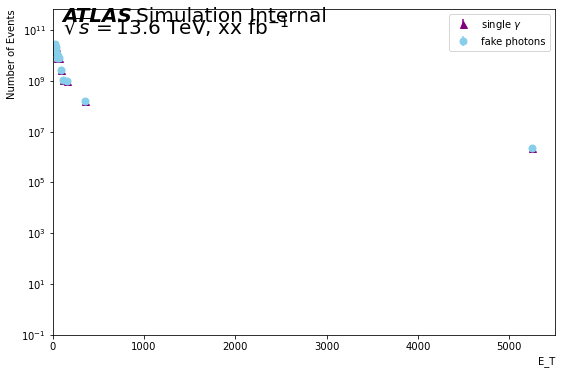

In [27]:
ap.ATLAShist(sigvarET,bkgvarET,'E_T',minmax=(0,5500),norm=False)

In [31]:
df_evenc['abs_eta']=abs(df_evenc.y_eta)

In [32]:
sigpost_eta = makebhvar(df_evenc,'abs_eta',binedgesETA,boolslice=df_evenc.y_isTruthMatchedPhoton,weightname='finalWeight')
bkgpost_eta = makebhvar(df_evenc,'abs_eta',binedgesETA,boolslice=~df_evenc.y_isTruthMatchedPhoton,weightname='finalWeight')

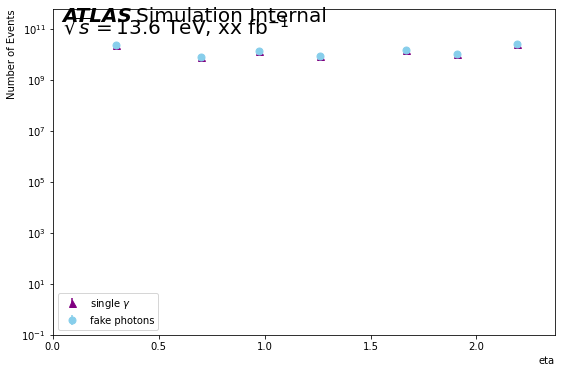

In [33]:
ap.ATLAShist(sigpost_eta,bkgpost_eta,'eta',minmax=(0,2.37),norm=False)

In [ ]:
###just using space to make a function

In [ ]:
def weightmaker(df,variable,binedges,inputweight='goodWeight'):
    '''returns an array of weights, such that
    the signal and background of DataFrame <df> are equal in counts
    of p_t (E_T) bins or eta bins
    
    df is DataFrame
    variable (str) is name of column to equalize counts to (e.g. 'abs_eta' or 'y_pt')
    binedges (list) is a list of the bin edges
    inputweight (str) is the name of the weight to start with (usually either 'goodWeight' or 'newWeight')
    
    reweights the signal events to match background events in binned counts of <variable>
    '''
    sigvar = makebhvar(df,variable,binedges,boolslice=df.y_isTruthMatchedPhoton,weightname=inputweight)
    bkgvar = makebhvar(df,variable,binedges,boolslice=~df.y_isTruthMatchedPhoton,weightname=inputweight)
    bkgvals = histvals(bkgvar)    #not normed, right?
    sigvals = histvals(sigvar)
    ratioforsig = bkgvals/sigvals  #will have some nans and infs
    df[variable+'Weight'] = reweight(df,binedges,ratioforsig,variable)
    outputlist = np.multiply(np.array(df[inputweight], np.array(df[variable+'Weight'])
    return outputlist

                 

In [ ]:
### for makepickledata.py file

df_evenu['abs_eta'] = abs(df_evenu.y_eta)
df_evenu['newWeight'] = ap.weightmaker(df_evenu,'abs_eta',binedgesETA,'goodWeight')
df_evenu['finalWeight'] = ap.weightmaker(df_evenu,'y_pt', binedgesET, 'newWeight')

print('\nweights applied to even unconverted\n')

# SECOND, even converted

df_evenc['abs_eta'] = abs(df_evenc.y_eta)
df_evenc['newWeight'] = ap.weightmaker(df_evenc,'abs_eta',binedgesETA,'goodWeight')
df_evenc['finalWeight'] = ap.weightmaker(df_evenc,'y_pt', binedgesET, 'newWeight')

print('\nweights applied to even converted\n')

# THIRD, odd unconverted

df_oddu['abs_eta'] = abs(df_oddu.y_eta)
df_oddu['newWeight'] = ap.weightmaker(df_oddu,'abs_eta',binedgesETA,'goodWeight')
df_oddu['finalWeight'] = ap.weightmaker(df_oddu,'y_pt', binedgesET, 'newWeight')

print('\nweights applied to odd unconverted\n')

#LAST, odd converted

df_oddc['abs_eta'] = abs(df_oddc.y_eta)
df_oddc['newWeight'] = ap.weightmaker(df_oddc,'abs_eta',binedgesETA,'goodWeight')
df_oddc['finalWeight'] = ap.weightmaker(df_oddc,'y_pt', binedgesET, 'newWeight')


In [ ]:
df_evenu['abs_eta'] = abs(df_evenu.y_eta)
sigvarETA = ap.makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarETA = ap.makebhvar(df_evenu,'abs_eta',binedgesETA,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvalsETA = ap.histvals(bkgvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsETA = ap.histvals(sigvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigETA = bkgvalsETA/sigvalsETA  #will have some nans and infs
df_evenu['etaWeight'] = ap.reweight(df_evenu,binedgesETA,ratioforsigETA,'abs_eta')
df_evenu['newWeight'] = np.multiply( np.array(df_evenu.goodWeight), np.array(df_evenu.etaWeight) )

sigvarET = ap.makebhvar(df_evenu,'y_pt',binedgesET,boolslice=df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvarET = ap.makebhvar(df_evenu,'y_pt',binedgesET,boolslice=~df_evenu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvalsET = ap.histvals(bkgvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsET = ap.histvals(sigvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigET = bkgvalsET/sigvalsET  #will have some nans and infs
df_evenu['etWeight'] = ap.reweight(df_evenu,binedgesET,ratioforsigET,'y_pt')
df_evenu['finalWeight'] = np.multiply( np.array(df_evenu.newWeight), np.array(df_evenu.etWeight) )

print('\nweights applied to even unconverted\n')

# SECOND, even converted

df_evenc['abs_eta'] = abs(df_evenc.y_eta)
sigvarETA = ap.makebhvar(df_evenc,'abs_eta',binedgesETA,boolslice=df_evenc.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarETA = ap.makebhvar(df_evenc,'abs_eta',binedgesETA,boolslice=~df_evenc.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvalsETA = ap.histvals(bkgvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsETA = ap.histvals(sigvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigETA = bkgvalsETA/sigvalsETA  #will have some nans and infs
df_evenc['etaWeight'] = ap.reweight(df_evenc,binedgesETA,ratioforsigETA,'abs_eta')
df_evenc['newWeight'] = np.multiply( np.array(df_evenc.goodWeight), np.array(df_evenc.etaWeight) )

sigvarET = ap.makebhvar(df_evenc,'y_pt',binedgesET,boolslice=df_evenc.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvarET = ap.makebhvar(df_evenc,'y_pt',binedgesET,boolslice=~df_evenc.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvalsET = ap.histvals(bkgvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsET = ap.histvals(sigvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigET = bkgvalsET/sigvalsET  #will have some nans and infs
df_evenc['etWeight'] = ap.reweight(df_evenc,binedgesET,ratioforsigET,'y_pt')
df_evenc['finalWeight'] = np.multiply( np.array(df_evenc.newWeight), np.array(df_evenc.etWeight) )

print('\nweights applied to even converted\n')


# THIRD, odd unconverted

df_oddu['abs_eta'] = abs(df_oddu.y_eta)
sigvarETA = ap.makebhvar(df_oddu,'abs_eta',binedgesETA,boolslice=df_oddu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarETA = ap.makebhvar(df_oddu,'abs_eta',binedgesETA,boolslice=~df_oddu.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvalsETA = ap.histvals(bkgvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsETA = ap.histvals(sigvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigETA = bkgvalsETA/sigvalsETA  #will have some nans and infs
df_oddu['etaWeight'] = ap.reweight(df_oddu,binedgesETA,ratioforsigETA,'abs_eta')
df_oddu['newWeight'] = np.multiply( np.array(df_oddu.goodWeight), np.array(df_oddu.etaWeight) )

sigvarET = ap.makebhvar(df_oddu,'y_pt',binedgesET,boolslice=df_oddu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvarET = ap.makebhvar(df_oddu,'y_pt',binedgesET,boolslice=~df_oddu.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvalsET = ap.histvals(bkgvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsET = ap.histvals(sigvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigET = bkgvalsET/sigvalsET  #will have some nans and infs
df_oddu['etWeight'] = ap.reweight(df_oddu,binedgesET,ratioforsigET,'y_pt')
df_oddu['finalWeight'] = np.multiply( np.array(df_oddu.newWeight), np.array(df_oddu.etWeight) )

print('\nweights applied to odd unconverted\n')


#LAST, odd converted

df_oddc['abs_eta'] = abs(df_oddc.y_eta)
sigvarETA = ap.makebhvar(df_oddc,'abs_eta',binedgesETA,boolslice=df_oddc.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvarETA = ap.makebhvar(df_oddc,'abs_eta',binedgesETA,boolslice=~df_oddc.y_isTruthMatchedPhoton,weightname='goodWeight')
bkgvalsETA = ap.histvals(bkgvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsETA = ap.histvals(sigvarETA)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigETA = bkgvalsETA/sigvalsETA  #will have some nans and infs
df_oddc['etaWeight'] = ap.reweight(df_oddc,binedgesETA,ratioforsigETA,'abs_eta')
df_oddc['newWeight'] = np.multiply( np.array(df_oddc.goodWeight), np.array(df_oddc.etaWeight) )

sigvarET = ap.makebhvar(df_oddc,'y_pt',binedgesET,boolslice=df_oddc.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvarET = ap.makebhvar(df_oddc,'y_pt',binedgesET,boolslice=~df_oddc.y_isTruthMatchedPhoton,weightname='newWeight')
bkgvalsET = ap.histvals(bkgvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
sigvalsET = ap.histvals(sigvarET)  ## SHOULD THESE BE NORMED OR NOT???? (rn going with not -- event count)
ratioforsigET = bkgvalsET/sigvalsET  #will have some nans and infs
df_oddc['etWeight'] = ap.reweight(df_oddc,binedgesET,ratioforsigET,'y_pt')
df_oddc['finalWeight'] = np.multiply( np.array(df_oddc.newWeight), np.array(df_oddc.etWeight) )

In [1]:
## making the reweight function vectorized

In [36]:
#original
def oldreweight(df,binedges,ratiolist,PTorETA='y_pt',sigorbkg='sig'):
    '''returns list of weights associated with applying
    binned weighting to the events in df_sig
    
    this function chooses which events to apply which weights to
    
    binedges is list of bin edges, length i+1
    ratiolist is list of reweighting ratios for each bin, length i
    PTorETA can be 'y_pt' (default) or 'y_eta' (or 'abs_eta' if made)
    sigorbkg can be 'sig' (default) or 'bkg'
        - this chooses whether the weighting is applied to the signal events or bkg events
    '''
    
    if sigorbkg == 'sig':
        truthsig = True
    elif sigorbkg == 'bkg':
        truthsig = False
    else:
        print('please pick \'sig\' or \'bkg\' for <sigorbkg>')
        return None
    
    eventlist = np.array(df[PTorETA])
    sigbkglist = np.array(df['y_isTruthMatchedPhoton'])
    reweightlist = []
    
    for event,sigbkg in zip(eventlist,sigbkglist):
        if sigbkg == truthsig:
            for i in range(len(ratiolist)):
                if (event>=binedges[i]) & (event<binedges[i+1]):
                    reweightlist.append(ratiolist[i])
        elif sigbkg != truthsig:
            reweightlist.append(1.)
        else:
            print('it should never get here, fix your code')
            return None
                
#     print('\nsize of eventlist: ',len(eventlist))
#     print('size of rewweightlist: ', len(reweightlist))
#     print('should match \n')
    
    return reweightlist

In [48]:
#vectorized:
def reweight(df,binedges,ratiolist,PTorETA='y_pt',sigorbkg='sig'):
    '''returns list of weights associated with applying
    binned weighting to the events in df_sig
    
    this function chooses which events to apply which weights to
    
    binedges is list of bin edges, length i+1
    ratiolist is list of reweighting ratios for each bin, length i
    PTorETA can be 'y_pt' (default) or 'y_eta' (or 'abs_eta' if made)
    sigorbkg can be 'sig' (default) or 'bkg'
        - this chooses whether the weighting is applied to the signal events or bkg events
    '''
    
    if sigorbkg == 'sig':
        truthsig = True
    elif sigorbkg == 'bkg':
        truthsig = False
    else:
        print('please pick \'sig\' or \'bkg\' for <sigorbkg>')
        return None
    
    eventlist = np.array(df[PTorETA])
    sigbkglist = np.array(df['y_isTruthMatchedPhoton'])
    
    reweightlist = np.array(pd.cut(eventlist,binedges,labels=ratiolist,include_lowest=True,ordered=False))
    
    if truthsig == True:
        reweightlist[~sigbkglist] = 1.
    elif truthsig == False:
        reweightlist[sigbkglist] = 1.
    else:
        print('it should never get here, fix your code')
        return None
    
    return reweightlist

In [42]:
listt= np.array([1,2,3,4,5,6])
booll = np.array([True, False, True, True, False, False])
listt[~booll] = 1.
listt

array([1, 1, 3, 4, 1, 1])

In [43]:
binedgesET, ratioforsigET

([0, 25, 30, 35, 40, 45, 50, 60, 80, 100, 120, 200, 500, 10000],
 array([8.09599059,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        nan,        nan]))

In [54]:
new = reweight(df_evenu,binedgesET,ratioforsigET,'y_pt')

In [55]:
old = np.array(oldreweight(df_evenu,binedgesET,ratioforsigET,'y_pt'))

In [58]:
new == old

array([ True,  True,  True, ...,  True,  True,  True])

In [60]:
sum(~(new == old))

0

In [79]:
## now vectorizing make hadlist too

#old:
def oldmakehadlist(df_name):
    '''Makes the list of values for the combined HadLeakage variable
    where HadLeakage = Rhad if 0.8<|eta|<1.37   and   
                       Rhad1 elsewhere
    df_name is the dataframe
    
    ***could remake this function to just append to the list instead of 
    inserting at specific indices (as long as it goes through everything in order)***
    
    -- df['column'].iloc[i] is used because indexing of a pandas series works differently than df['column'][i]'''
    
    hadleaklist = [False] * len(df_name['y_eta'])
    
#     print(np.array(df_name['y_eta']))
    
    for i in range(len(df_name['y_eta'])):
#         print(abs(df_name['y_eta'].iloc[i]))
        if abs(df_name['y_eta'].iloc[i]) < 0.8 or abs(df_name['y_eta'].iloc[i]) > 1.37:
            hadleaklist[i] = df_name['y_Rhad1'].iloc[i]
        else:
            hadleaklist[i] = df_name['y_Rhad'].iloc[i]
         
    return hadleaklist

In [131]:
#new
def makehadlist(df_name):
    '''Makes the list of values for the combined HadLeakage variable
    where HadLeakage = Rhad if 0.8<|eta|<1.37   and   
                       Rhad1 elsewhere
    df_name is the dataframe
    
    ***could remake this function to just append to the list instead of 
    inserting at specific indices (as long as it goes through everything in order)***
    
    -- df['column'].iloc[i] is used because indexing of a pandas series works differently than df['column'][i]'''
    
    hadleaklist = [False] * len(df_name['y_eta'])
    
    abseta = np.array(abs(df_name['y_eta']))
    bins = [0, 0.8, 1.37, float('inf')]
    labels = [False,True,False]  #True if Rhad, False if Rhad1
    
    Rhadbool = np.array(pd.cut(abseta,bins,labels=labels,include_lowest=True,ordered=False))  #True if Rhad, False if Rhad1
    Rhad1list = np.array(df_name['y_Rhad1'])
    Rhadlist = np.array(df_name['y_Rhad'])
    
    hadleaklist = np.array([0.]*len(abseta))
    hadleaklist[Rhadbool] = Rhadlist[Rhadbool]
    hadleaklist[~Rhadbool] = Rhad1list[~Rhadbool]
         
    return hadleaklist

In [123]:
list1 = np.array([0.,0.,0.,0.])
list2 = np.array([5.2555,6.6894,7.134,8.2498])
boola = np.array([True, False, True, False])
list1[boola] = list2[boola]
list1

array([5.2555, 0.    , 7.134 , 0.    ])

In [86]:
np.array([0]*10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [87]:
# one = pd.Interval(left=0,right=0.8,closed='both')
# two = pd.Interval(left=0.8,right=1.37,closed='neither')
# three = pd.Interval(left=1.37,right=float('inf'),closed='left')
# pd.IntervalIndex(np.array([one,two,three]))
# # pd.IntervalIndex([[0,0.8],(0.8,1.37),[1.37,float('inf')]])

In [88]:
float('inf')

inf

In [90]:
folder = '/eos/atlas/atlascerngroupdisk/perf-egamma/InclusivePhotons'
branches = ['evtWeight', 'mcWeight', 'mcTotWeight', 'yWeight', 'y_passOQ', 'y_pt', 'y_eta', 
            'y_isTruthMatchedPhoton', 'y_convType', 'y_Rhad1', 'y_Rhad',       #do we need y_convType thats not truth?
            'y_Reta', 'y_weta2', 'y_Rphi', 'y_wtots1', 'y_weta1', 'y_fracs1', 'y_deltae', 'y_Eratio', 'y_f1']
testdf = ap.fileloader(folder+'/mc20_gammajet_v09/PyPt8_inf_mc20a_p5536_Rel22_AB22.2.97_v09.root',branches,entry_stop=None,entry_start=-10000)

In [132]:
try1 = makehadlist(testdf)

In [133]:
try2 = oldmakehadlist(testdf)

In [134]:
try1

array([0.01039484, 0.00468968, 0.00592743, ..., 0.03190123, 0.00399474,
       0.00375587])

In [135]:
try2

[0.010394843,
 0.004689679,
 0.0059274323,
 0.018099377,
 0.006469841,
 0.031150026,
 0.017538264,
 0.0073621883,
 0.050340325,
 0.030037293,
 0.037021503,
 0.0010298288,
 0.00048116036,
 0.0008293139,
 0.027017204,
 0.0638909,
 0.023023855,
 0.0029093223,
 0.009334276,
 0.006230797,
 0.0005097475,
 0.02376629,
 0.025527893,
 0.12205328,
 0.0031524529,
 0.0026974624,
 0.021657694,
 0.0029756555,
 0.00048377732,
 0.0006037825,
 0.34358254,
 0.0015496322,
 0.40234682,
 0.010944327,
 0.094927765,
 0.027906701,
 -0.000382076,
 0.004248883,
 0.0047152005,
 0.009954163,
 0.000911156,
 0.0002478589,
 0.0003093356,
 0.0051026554,
 0.010043842,
 0.03783472,
 0.040812332,
 0.010328489,
 0.0031590501,
 0.25637007,
 0.0056458605,
 0.039070074,
 0.0046762777,
 0.029186282,
 0.001142052,
 0.009174349,
 0.008289881,
 0.0004391365,
 0.09749364,
 0.019517437,
 0.1264099,
 0.0037189822,
 0.15639882,
 0.042476654,
 0.0022932442,
 0.00085504114,
 0.013019984,
 0.04391753,
 0.0356799,
 0.009501096,
 0.0286

In [136]:
sum(~(try1 == try2))

0